In [ ]:
#!pip install torch torchvision --upgrade

In [2]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import numpy as np # linear algebra
import pandas as pd

cudnn.benchmark = True
plt.ion()
import torch
print(torch.__version__)


1.11.0


In [3]:
"""
train_transform=transforms.Compose([
        transforms.RandomRotation(10),      # rotate +/- 10 degrees
        transforms.RandomHorizontalFlip(),  # reverse 50% of images
        transforms.Resize(224),             # resize shortest side to 224 pixels
        transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
])
"""

'\ntrain_transform=transforms.Compose([\n        transforms.RandomRotation(10),      # rotate +/- 10 degrees\n        transforms.RandomHorizontalFlip(),  # reverse 50% of images\n        transforms.Resize(224),             # resize shortest side to 224 pixels\n        transforms.CenterCrop(224),         # crop longest side to 224 pixels at center\n        transforms.ToTensor(),\n        transforms.Normalize([0.485, 0.456, 0.406],\n                             [0.229, 0.224, 0.225])\n])\n'

In [4]:
"""
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(299),
        transforms.RandomHorizontalFlip(),
        #transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
        transforms.RandomRotation(10),
        #transforms.RandomPerspective(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(299),
        transforms.CenterCrop(299),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
"""

data_transforms = {
    'train': transforms.Compose([transforms.Resize(299),
        transforms.CenterCrop(299),
#         transforms.RandomResizedCrop(299),
#         transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(299),
        transforms.CenterCrop(299),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
image_path="/kaggle/input/rice-leaf-images/rice_images"#"/kaggle/input/riceleafs/RiceLeafs/train"
#"../input/rice-leaf-images/rice_images"
#input/rice-leaf-images/rice_images

In [6]:
from torchvision.datasets import ImageFolder
dataset=ImageFolder(image_path,transform=data_transforms["train"])
img,label=dataset[0]
print(img.shape,label)
print(dataset.classes)

torch.Size([3, 299, 299]) 0
['_BrownSpot', '_Healthy', '_Hispa', '_LeafBlast']


label:  _BrownSpot (0)


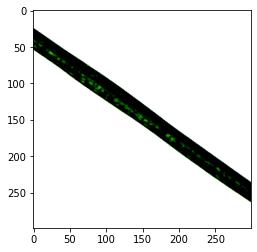

In [7]:

import matplotlib.pyplot as plt
def show_example(img,label):
    print("label: ",dataset.classes[label],"("+str(label)+")")
    plt.imshow(img.permute(1,2,0))
show_example(*dataset[0])  

label:  _BrownSpot (0)


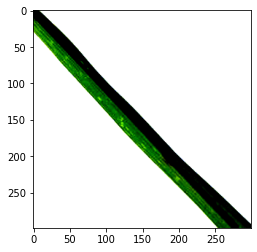

In [8]:
show_example(*dataset[1])

In [9]:
import numpy as np
def split_indices(n,val_pct=0.1,test_pct=0.2,seed=99):
    n_val=int(val_pct*n)
    n_test=int(test_pct*n)
    np.random.seed(seed)
    idxs=np.random.permutation(n)
    return idxs[:n_val],idxs[n_val:n_val+n_test],idxs[n_val+n_test:]
val_pct=0.1
test_pct=0.1
rand_seed=42
valid_indices,test_indices,train_indices=split_indices(len(dataset),val_pct,test_pct,rand_seed)

In [10]:
print("test_size",len(test_indices))
print("validiti_size",len(valid_indices))
print("train_size",len(train_indices))

test_size 335
validiti_size 335
train_size 2685


In [11]:
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader

In [12]:
batch_size=32
train_sampler=SubsetRandomSampler(train_indices)
valid_sampler=SubsetRandomSampler(valid_indices)
test_sampler=SubsetRandomSampler(test_indices)

In [13]:
train_dl=DataLoader(dataset,batch_size,sampler=train_sampler)
valid_dl=DataLoader(dataset,batch_size,sampler=valid_sampler)
test_dl=DataLoader(dataset,batch_size,sampler=test_sampler)

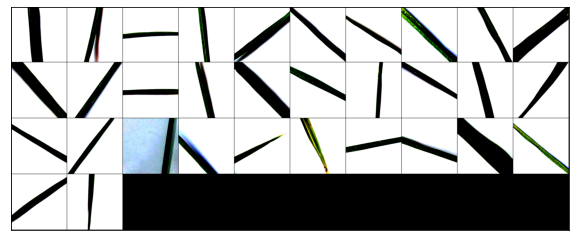

In [14]:
dataset_sizes={"train":len(train_indices),"val":len(valid_indices),"test":len(test_indices)}
from torchvision.utils import make_grid
def show_batch(dl):
    for image,label in dl:
        fig,ax=plt.subplots(figsize=(10,10))
        ax.set_xticks([]);ax.set_yticks([])
        ax.imshow(make_grid(image,10).permute(1,2,0))
        break
show_batch(train_dl)

In [15]:
dataloaders={"train":train_dl,"val":valid_dl,"test":test_dl}

In [16]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [17]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [18]:
"""
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 4.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 4)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)
"""

'\nmodel_ft = models.resnet50(pretrained=True)\nnum_ftrs = model_ft.fc.in_features\n# Here the size of each output sample is set to 4.\n# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).\nmodel_ft.fc = nn.Linear(num_ftrs, 4)\n\nmodel_ft = model_ft.to(device)\n\ncriterion = nn.CrossEntropyLoss()\n\n# Observe that all parameters are being optimized\noptimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)\n\n# Decay LR by a factor of 0.1 every 7 epochs\nexp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)\nmodel_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,\n                       num_epochs=25)\n'

In [19]:
num_epochs=25

### traing ResNet50 on dataset A

In [20]:
"""
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 4.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 4)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

best_model_wts = copy.deepcopy(model_ft.state_dict())
best_loss = float('inf')

for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
        if phase == 'train':
            model_ft.train()  # Set model to training mode
        else:
            model_ft.eval()   # Set model to evaluate mode

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer_ft.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model_ft(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer_ft.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

        # deep copy the model
        if phase == 'val' and epoch_loss < best_loss:
            best_loss = epoch_loss
            best_model_wts = copy.deepcopy(model_ft.state_dict())

    exp_lr_scheduler.step()

# load best model weights
model_ft.load_state_dict(best_model_wts)

# save the best model weights
torch.save(best_model_wts, 'best_model_ResNet50.pth')
"""

"\nmodel_ft = models.resnet50(pretrained=True)\nnum_ftrs = model_ft.fc.in_features\n# Here the size of each output sample is set to 4.\n# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).\nmodel_ft.fc = nn.Linear(num_ftrs, 4)\n\nmodel_ft = model_ft.to(device)\n\ncriterion = nn.CrossEntropyLoss()\n\n# Observe that all parameters are being optimized\noptimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)\n\n# Decay LR by a factor of 0.1 every 7 epochs\nexp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)\n\nbest_model_wts = copy.deepcopy(model_ft.state_dict())\nbest_loss = float('inf')\n\nfor epoch in range(num_epochs):\n    print('Epoch {}/{}'.format(epoch, num_epochs - 1))\n    print('-' * 10)\n\n    # Each epoch has a training and validation phase\n    for phase in ['train', 'val']:\n        if phase == 'train':\n            model_ft.train()  # Set model to training mode\n        else:\n            model_ft.eval()  

### Training the Resnet50 on dataset B

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Epoch 0/24
----------
train Loss: 0.5310 Acc: 0.8223
val Loss: 0.5118 Acc: 0.8000
Epoch 1/24
----------
train Loss: 0.2994 Acc: 0.8939
val Loss: 0.3694 Acc: 0.8567
Epoch 2/24
----------
train Loss: 0.1756 Acc: 0.9441
val Loss: 0.4484 Acc: 0.8507
Epoch 3/24
----------
train Loss: 0.1110 Acc: 0.9669
val Loss: 0.4176 Acc: 0.8597
Epoch 4/24
----------
train Loss: 0.0788 Acc: 0.9765
val Loss: 0.4729 Acc: 0.8418
Epoch 5/24
----------
train Loss: 0.0415 Acc: 0.9933
val Loss: 0.5945 Acc: 0.8478
Epoch 6/24
----------
train Loss: 0.0563 Acc: 0.9862
val Loss: 0.4811 Acc: 0.8627
Epoch 7/24
----------
train Loss: 0.0344 Acc: 0.9929
val Loss: 0.4188 Acc: 0.8567
Epoch 8/24
----------
train Loss: 0.0190 Acc: 0.9978
val Loss: 0.4142 Acc: 0.8806
Epoch 9/24
----------
train Loss: 0.0142 Acc: 0.9993
val Loss: 0.4000 Acc: 0.8657
Epoch 10/24
----------
train Loss: 0.0143 Acc: 0.9996
val Loss: 0.4017 Acc: 0.8716
Epoch 11/24
----------
train Loss: 0.0128 Acc: 0.9996
val Loss: 0.4044 Acc: 0.8687
Epoch 12/24
--

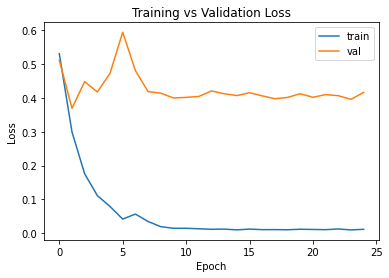

In [24]:
import matplotlib.pyplot as plt
import numpy as np

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    train_loss = []
    train_acc = []
    val_loss = []
    val_acc = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)
            else:
                val_loss.append(epoch_loss)
                val_acc.append(epoch_acc)

                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())

        scheduler.step()

    model.load_state_dict(best_model_wts)
    return model, train_loss, train_acc, val_loss, val_acc

###############

# Load the pre-trained weights from the saved state dictionary
state_dict = torch.load('/kaggle/input/rice-weights/best_model_ResNet50.pth')

# Create a new instance of the ResNet50 model and replace the last layer with a new layer
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 4)

# Load the pre-trained weights into the new model instance and move the model to the device
model_ft.load_state_dict(state_dict)
model_ft = model_ft.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

###
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
# Train the model and collect loss and accuracy values
model_ft, train_loss, train_acc, val_loss, val_acc = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

# Plot the training and validation losses at each epoch
plt.plot(np.arange(len(train_loss)), train_loss, label='train')
plt.plot(np.arange(len(val_loss)), val_loss, label='val')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Load the pre-trained weights from the saved state dictionary
state_dict = torch.load('/kaggle/input/rice-weights/best_model_ResNet50.pth')

# Create a new instance of the ResNet50 model and replace the last layer with a new layer
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 4)

# Load the pre-trained weights into the new model instance and move the model to the device
model_ft.load_state_dict(state_dict)
model_ft = model_ft.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

###
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


# Train the model on datasetB
best_model_wts = copy.deepcopy(model_ft.state_dict())
best_loss = float('inf')

for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
        if phase == 'train':
            model_ft.train()  # Set model to training mode
        else:
            model_ft.eval()   # Set model to evaluate mode

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer_ft.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model_ft(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer_ft.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

        # deep copy the model
        if phase == 'val' and epoch_loss < best_loss:
            best_loss = epoch_loss
            best_model_wts = copy.deepcopy(model_ft.state_dict())

    exp_lr_scheduler.step()

# Save the best model weights trained on datasetB
torch.save(best_model_wts, 'best_model_ResNet50_datasetB.pth')
torch.save(model_ft.state_dict(), 'modelresnet50dict.pth')
# Save the entire model to a file
torch.save(model_ft, 'Entire_resnet50_model.pth')

In [ ]:
#model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
#                      num_epochs=25)

In [ ]:
# visualize_model(model_ft)

In [21]:
def validation(valid_dl,model,device="cpu"):
    correct=total=0
    with torch.no_grad():
        for images,labels in valid_dl:
            images,labels=images.to(device),labels.to(device)
            output=model(images)
            _,pred=torch.max(output.data,1)
            total+=labels.size(0)
            correct+=(pred==labels).sum().item()
    return (correct/total)*100  

Accuracy on validation set: 91.64%
              precision    recall  f1-score   support

         0.0       0.96      0.87      0.91        52
         1.0       0.91      0.96      0.94       158
         2.0       0.86      0.80      0.83        54
         3.0       0.94      0.94      0.94        71

    accuracy                           0.92       335
   macro avg       0.92      0.89      0.90       335
weighted avg       0.92      0.92      0.92       335



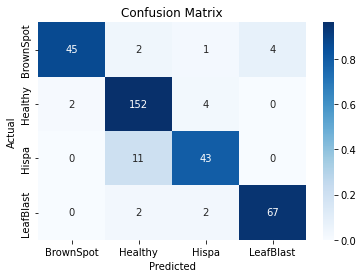

test_accuracy for resnet 50 ; 91.64179104477613


In [26]:
ans1=validation(test_dl,model_ft,device)
print("test_accuracy for resnet 50 ; {}".format(ans1))

In [25]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

def validation(valid_dl, model, device="cpu"):
    correct = total = 0
    y_true = np.array([])
    y_pred = np.array([])
    with torch.no_grad():
        for images, labels in valid_dl:
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            _, pred = torch.max(output.data, 1)
            total += labels.size(0)
            correct += (pred == labels).sum().item()
            y_true = np.concatenate((y_true, labels.cpu().numpy()))
            y_pred = np.concatenate((y_pred, pred.cpu().numpy()))
    accuracy = (correct / total) * 100
    print('Accuracy on validation set: {:.2f}%'.format(accuracy))
    print(classification_report(y_true, y_pred))

    # Generate confusion matrix plot
    cm = confusion_matrix(y_true, y_pred)
    class_names = ['BrownSpot', 'Healthy', 'Hispa', 'LeafBlast']
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm_norm, annot=cm, cmap='Blues', fmt='g', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    return (correct/total)*100 


In [ ]:
ans1=validation(test_dl,model_ft,device)
print("test_accuracy for resnet50 ; {}".format(ans1))

### Training inceptionV3 on dataset A 

In [ ]:
"""
model_inc  = torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', pretrained=True)
model_inc.aux_logits=False
num_ftrs = model_inc.fc.in_features
# Here the size of each output sample is set to 4.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_inc.fc = nn.Linear(num_ftrs, 4)

model_inc = model_inc.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_inc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

best_model_wts = copy.deepcopy(model_inc.state_dict())
best_loss = float('inf')

for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
        if phase == 'train':
            model_inc.train()  # Set model to training mode
        else:
            model_inc.eval()   # Set model to evaluate mode

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer_ft.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model_inc(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer_ft.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

        # deep copy the model
        if phase == 'val' and epoch_loss < best_loss:
            best_loss = epoch_loss
            best_model_wts = copy.deepcopy(model_inc.state_dict())

    exp_lr_scheduler.step()

# load best model weights
model_inc.load_state_dict(best_model_wts)

# save the best model weights
torch.save(best_model_wts, 'best_model_inception_v3.pth')
"""

### Training inception_v3 model on dataset B

Downloading: "https://github.com/pytorch/vision/archive/v0.10.0.zip" to /root/.cache/torch/hub/v0.10.0.zip
/opt/conda/lib/python3.7/site-packages/torchvision/models/inception.py:48: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  FutureWarning,


Epoch 0/24
----------
train Loss: 0.6213 Acc: 0.7873
val Loss: 0.4938 Acc: 0.8149
Epoch 1/24
----------
train Loss: 0.3982 Acc: 0.8588
val Loss: 0.3955 Acc: 0.8716
Epoch 2/24
----------
train Loss: 0.2688 Acc: 0.9058
val Loss: 0.4069 Acc: 0.8687
Epoch 3/24
----------
train Loss: 0.1871 Acc: 0.9356
val Loss: 0.4631 Acc: 0.8328
Epoch 4/24
----------
train Loss: 0.1435 Acc: 0.9546
val Loss: 0.3728 Acc: 0.8806
Epoch 5/24
----------
train Loss: 0.1187 Acc: 0.9635
val Loss: 0.3751 Acc: 0.8925
Epoch 6/24
----------
train Loss: 0.0908 Acc: 0.9709
val Loss: 0.3925 Acc: 0.8776
Epoch 7/24
----------
train Loss: 0.0552 Acc: 0.9885
val Loss: 0.3387 Acc: 0.8896
Epoch 8/24
----------
train Loss: 0.0393 Acc: 0.9929
val Loss: 0.3379 Acc: 0.8836
Epoch 9/24
----------
train Loss: 0.0382 Acc: 0.9933
val Loss: 0.3434 Acc: 0.8985
Epoch 10/24
----------
train Loss: 0.0280 Acc: 0.9966
val Loss: 0.3386 Acc: 0.8896
Epoch 11/24
----------
train Loss: 0.0332 Acc: 0.9940
val Loss: 0.3333 Acc: 0.8985
Epoch 12/24
--

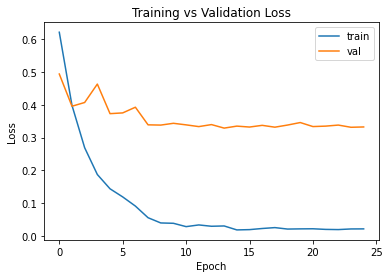

In [27]:
best_model_wts = torch.load('/kaggle/input/rice-weights/best_model_inception_v3.pth')
model_inc = torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', pretrained=False)
model_inc.aux_logits = False
num_ftrs = model_inc.fc.in_features
model_inc.fc = nn.Linear(num_ftrs, 4)
model_inc.load_state_dict(best_model_wts)
model_inc = model_inc.to(device)
optimizer_ft = optim.SGD(model_inc.parameters(), lr=0.001, momentum=0.9)

best_model_wts = copy.deepcopy(model_inc.state_dict())
best_loss = float('inf')
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_inc, train_loss, train_acc, val_loss, val_acc = train_model(model_inc, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

# Plot the training and validation losses at each epoch
plt.plot(np.arange(len(train_loss)), train_loss, label='train')
plt.plot(np.arange(len(val_loss)), val_loss, label='val')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


# load best model weights
model_inc.load_state_dict(best_model_wts)

# save the best model weights
torch.save(best_model_wts, 'best_model_inception_v3_B.pth')


In [ ]:
# save the best model weights
#torch.save(best_model_wts, 'best_model_inception_v3_B.pth')

Accuracy on validation set: 30.45%
              precision    recall  f1-score   support

         0.0       0.50      0.02      0.04        52
         1.0       0.49      0.35      0.41       158
         2.0       0.67      0.04      0.07        54
         3.0       0.20      0.62      0.30        71

    accuracy                           0.30       335
   macro avg       0.46      0.26      0.20       335
weighted avg       0.46      0.30      0.27       335



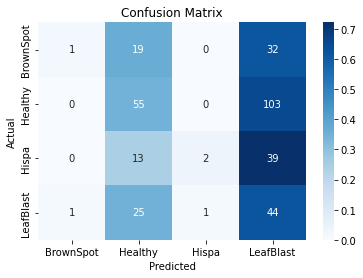

test_accuracy for inceptionv3 ; 30.447761194029848


In [28]:
ans1=validation(test_dl,model_inc,device)
print("test_accuracy for inceptionv3 ; {}".format(ans1))